In [33]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.applications import EfficientNetV2B0

In [2]:
train_path = './RetinalOCT_Dataset/train/'
test_path = './RetinalOCT_Dataset/test/'
val_path = './RetinalOCT_Dataset/val/'
classes = ['AMD','CNV','CSR','DME','DR','DRUSEN','MH','NORMAL']

In [3]:
def load_dataset(base_path):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        folder_path = os.path.join(base_path, class_name)
        for img in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (256, 256))
            
            #Contrast enhancement
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            cl = clahe.apply(l)
            limg = cv2.merge((cl, a, b))
            img = cv2.cvtColor(limg, cv2.COLOR_Lab2RGB)

            img = img.astype(np.float32) / 255.0

            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# train_images, train_labels = load_dataset(train_path)
# val_images, val_labels = load_dataset(val_path)
# test_images, test_labels = load_dataset(test_path)

In [5]:
# save npz file (nanti bisa tinggal load)
# np.savez("train.npz", images=train_images, labels=train_labels)
# np.savez("val.npz", images=val_images, labels=val_labels)
# np.savez("test.npz", images=test_images, labels=test_labels)

In [15]:
train_npz = "train.npz"
val_npz   = "val.npz"
test_npz  = "test.npz"

AUTOTUNE = tf.data.AUTOTUNE
IMG_SHAPE = (256, 256, 3)
BATCH_SIZE = 16
num_classes = 8

In [16]:
def make_generator(npz_path):
    def gen():
        data = np.load(npz_path)
        images = data['images']
        labels = data['labels']
        n = images.shape[0]
        for i in range(len(images)):
            yield images[i], labels[i]
    return gen

In [17]:
augmentation = Sequential([
    layers.RandomRotation(0.03),
], name="aug_layer")

def build_dataset_from_npz(npz_path, batch_size=BATCH_SIZE, shuffle=False):
    gen = make_generator(npz_path)

    output_signature = (
        tf.TensorSpec(shape=IMG_SHAPE, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)

    if shuffle:
        ds = ds.shuffle(2048)

    def preprocess(image, label):
        image = tf.cast(image, tf.float32)

        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = augmentation(tf.expand_dims(image, 0))[0]

        image = tf.clip_by_value(image, 0.0, 1.0)
        image = image * 255.0

        image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
        return image, label

    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [18]:
train_ds = build_dataset_from_npz(train_npz, shuffle=True)
val_ds   = build_dataset_from_npz(val_npz)
test_ds  = build_dataset_from_npz(test_npz)

In [10]:
# train_data = np.load('train.npz')
# train_images = train_data['images']
# train_labels = train_data['labels']

# test_data = np.load('test.npz')
# test_images = test_data['images']
# test_labels = test_data['labels']

# val_data = np.load('val.npz')
# val_images = val_data['images']
# val_labels = val_data['labels']

In [19]:
base = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

base.trainable = False

In [20]:
inputs = layers.Input(shape=(256, 256, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [21]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,934,680 (22.64 MB)

 Trainable params: 12,808 (50.03 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss', min_lr=1e-4)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


   1150/Unknown 335s 232ms/step - accuracy: 0.8005 - loss: 0.6704

d:\Python\DL\environments\deep_learning\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 383s 274ms/step - accuracy: 0.8480 - loss: 0.5296 - val_accuracy: 0.5393 - val_loss: 1.9046 - learning_rate: 0.0010
Epoch 2/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 5248s 4s/step - accuracy: 0.8769 - loss: 0.4483 - val_accuracy: 0.6286 - val_loss: 1.7440 - learning_rate: 0.0010
Epoch 3/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 395s 299ms/step - accuracy: 0.8845 - loss: 0.4194 - val_accuracy: 0.6039 - val_loss: 1.7969 - learning_rate: 0.0010
Epoch 4/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 398s 303ms/step - accuracy: 0.8891 - loss: 0.4138 - val_accuracy: 0.6525 - val_loss: 1.4798 - learning_rate: 0.0010
Epoch 5/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 393s 302ms/step - accuracy: 0.8909 - loss: 0.3890 - val_accuracy: 0.6307 - val_loss: 1.5203 - learning_rate: 0.0010
Epoch 6/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 462s 308ms/step - accuracy: 0.8946 - loss: 0.3882 - val_accuracy: 0.6882 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 7/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 389s 297ms/step - accur

In [23]:
model.save("efficientnetv2_stage1.h5")

In [24]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_stage2.keras",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss', min_lr=1e-6),
    checkpoint
]

In [25]:
base.trainable = True

for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
   1150/Unknown 396s 310ms/step - accuracy: 0.5221 - loss: 1.4777

d:\Python\DL\environments\deep_learning\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 453s 359ms/step - accuracy: 0.6103 - loss: 1.1394 - val_accuracy: 0.8032 - val_loss: 0.5102 - learning_rate: 1.0000e-05
Epoch 2/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 458s 357ms/step - accuracy: 0.6763 - loss: 0.9321 - val_accuracy: 0.8293 - val_loss: 0.4605 - learning_rate: 1.0000e-05
Epoch 3/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 450s 352ms/step - accuracy: 0.7050 - loss: 0.8468 - val_accuracy: 0.8400 - val_loss: 0.4427 - learning_rate: 1.0000e-05
Epoch 4/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 455s 355ms/step - accuracy: 0.7235 - loss: 0.7709 - val_accuracy: 0.8521 - val_loss: 0.4044 - learning_rate: 1.0000e-05
Epoch 5/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 458s 363ms/step - accuracy: 0.7470 - loss: 0.7208 - val_accuracy: 0.8454 - val_loss: 0.4190 - learning_rate: 1.0000e-05
Epoch 6/50
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 462s 362ms/step - accuracy: 0.7558 - loss: 0.7070 - val_accuracy: 0.8421 - val_loss: 0.3947 - learning_rate: 1.0000e-05
Epoch 7/50
1150/1150 ━━━━━━━━━━━━━━━━━━

In [26]:
model.save("efficientnet_oct_model.h5")

In [ ]:
model = tf.keras.models.load_model("efficientnet_oct_model.h5")

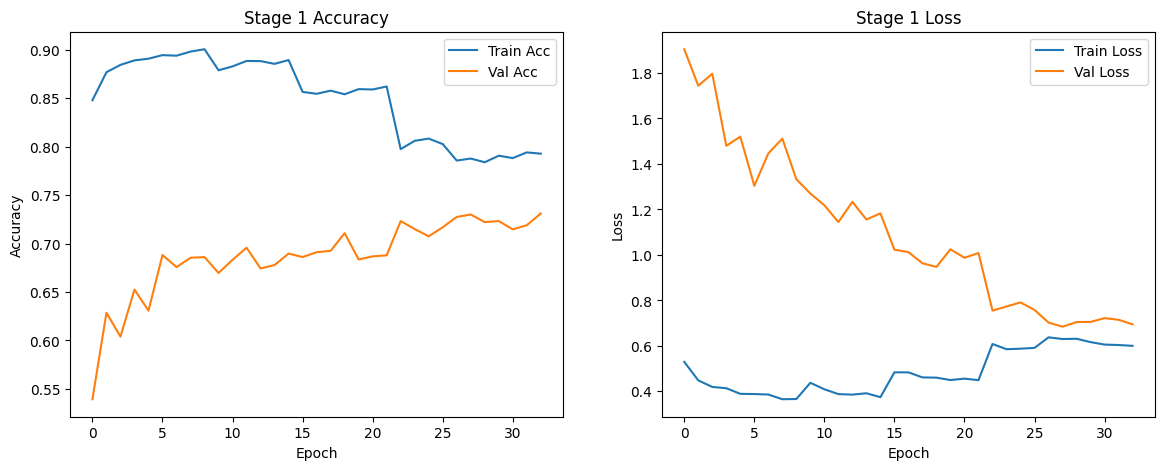

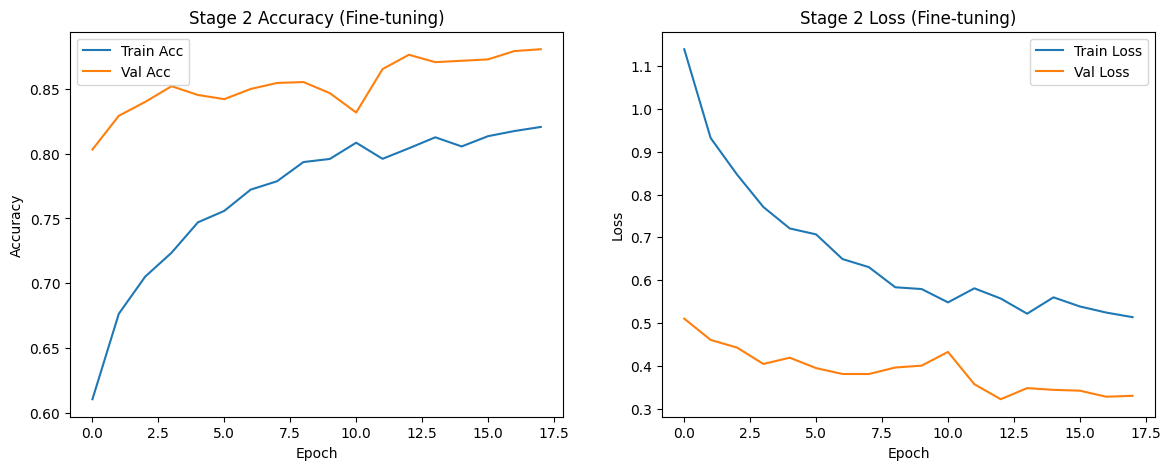

In [28]:
# Stage 1
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Stage 1 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Stage 1 Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Stage 2
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Stage 2 Accuracy (Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Stage 2 Loss (Fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [29]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy = {test_acc:.4f}")
print(f"Test Loss = {test_loss:.4f}")

175/175 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.8761 - loss: 0.3328
Test Accuracy = 0.8761
Test Loss = 0.3328


d:\Python\DL\environments\deep_learning\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [31]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

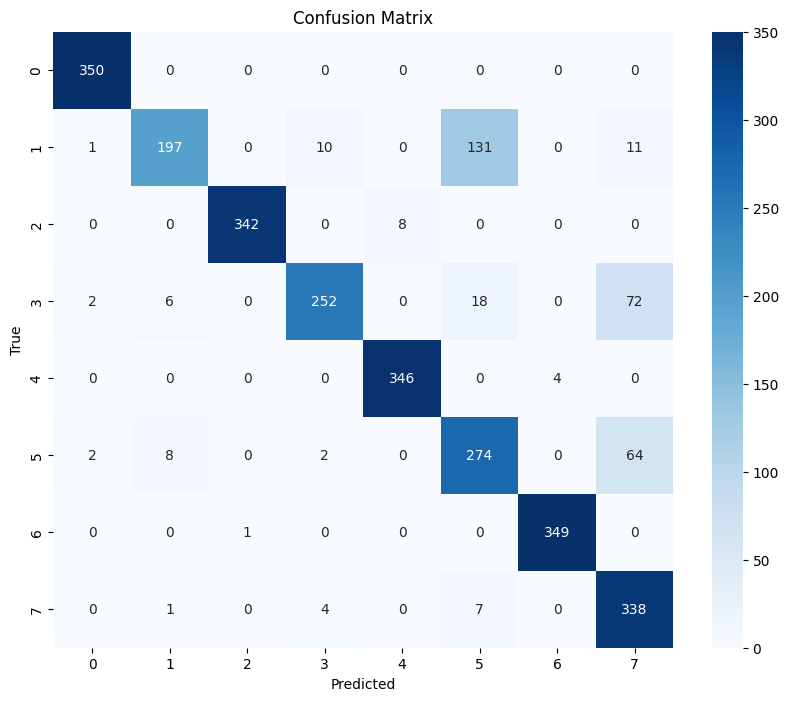

In [35]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()